In [6]:
%matplotlib inline
import numpy as np, pickle, threading, pyaudio, cv2, time, matplotlib.pyplot as plt, math
from IPython.display import clear_output

In [2]:
def takePhoto(adaptTime=2):
    cap = cv2.VideoCapture(0)
    # 初始化摄像头，摄像头适应光源
    for _ in range(adaptTime):
        cap.read()
    ret, frame = cap.read()
    if not ret:
        print('camera not working')
#         return None
    cap.release()
    print('Image shape: ', frame.shape)
    return frame

In [3]:
img = takePhoto()
data = img[200:202, 300:305, 0].reshape(-1)
print(data)

Image shape:  (480, 640, 3)
[24 21 19 19 21 25 22 21 22 22]


In [12]:
class NeuronCell(object):
    def __init__(self, ID, threshold, initWeight):
        self.id = ID
        # 数据 id: input data
        self.data = {
            'in': {}, 
            'out': {}
        }
        # 权值 id: weight
        self.weights = {
            'in': {}, 
            'out': {}
        }
        # 聚合数据大小
        self.totalData = 0
        # 激发阙值
        self.threshold = threshold
        # 初始权值
        self.initWeight = initWeight
        # 连接数
        self.connected = {
            'in': 0, 
            'out': 0
        }
        # 最大数据
        self.maxData = 100
        
    # conn = True or False, port = 'in' or 'out'
    def conn(self, conn, port, ID):
        if conn:
            self.data[port][ID] = 0
            self.weights[port][ID] = self.initWeight
            self.connected[port] += 1
        else:
            del self.data[port][ID]
            del self.weights[port][ID]
            self.connected[port] -= 1
        # 连接成功
        return True
    
    def inputData(self, data, sourceID):
        self.data['in'][sourceID] = data
    
    def prepareForFire(self):
        if len(self.data['in']):
            inputs = np.array(list(self.data['in'].values()), dtype=np.float16)
            weightsIn = np.array(list(self.weights['in'].values()), dtype=np.float16)
            self.totalData = np.sum(inputs * weightsIn)
        for Id in self.data['in'].keys():
            self.data['in'][Id] = 0
        
    def fire(self):
        if math.isinf(self.totalData) or self.totalData > self.maxData:
            self.totalData = self.maxData
            
        if self.totalData > self.threshold:
            weightsOut = np.array(list(self.weights['out'].values()), dtype=np.float16)
            dataOut = self.leakyRelu(weightsOut * self.totalData).tolist()
            IDs = list(self.data['out'].keys())
            self.data['out'] = dict(zip(IDs, dataOut))
            self.totalData = 0
            # 返回激发成功
            return True
        # 激发失败
        return False
            
    def transToTarget(self, neurons):
        for Id, data in self.data['out'].items():
            neurons[Id].inputData(data, self.id)
            self.data['out'][Id] = 0
        return set(self.data['out'].keys())
    
    def sortById(self, port):
        if port == 'all':
            self.data['in'] = dict(sorted(self.data['in'].items()))
            self.data['out'] = dict(sorted(self.data['out'].items()))
            self.weights['in'] = dict(sorted(self.weights['in'].items()))
            self.weights['out'] = dict(sorted(self.weights['out'].items()))
        else:
            self.data[port] = dict(sorted(self.data[port].items()))
            self.weights[port] = dict(sorted(self.weights[port].items()))
    
    def leakyRelu(self, x, p=0.01):
        return np.maximum(x, x*p)
    
    def updateWeight(self, port, neuronID, times):
        self.weights[port][neuronID] *= times
        self.weights[port][neuronID] = min(self.weights[port][neuronID], 1)
        
    # stdp学习方法，两个神经元放电时间 <= 5ms,则连接权重增加70%, 否则减少20%
    def stdp(self, fire, absoluteID):
        # 1.7^(1/2) = 1.3   0.8^(1/2) = 0.89
        weightTimes = {
            'in': (1.25, 0.95), 
            'out': (1.4, 0.85)
        }
        index = 0 if fire else 1
        for port, weights in self.weights.items():
            for ID, weight in weights.items():
                # 如果本神经元fire为True,则增加权重，否则减少
                self.updateWeight(port, ID, weightTimes[port][index])
                if port == 'in':
                    absoluteID[ID].updateWeight('out', self.id, weightTimes['out'][index])
    
    def getParams(self):
        params = {
            'weights': self.weights, 
            'threshold': self.threshold, 
            'connected': self.connected
        }
        return params

In [13]:
class Brain(object):
    def __init__(self):
        # 神经元数量
        self.neuronNum = 0
        # 所有神经元, id: neuron
        self.absoluteID = {}
        # 神经元分区
        self.sections = {
            'input':dict(), 
            'think':dict(), 
            'output':dict()
        }
        # 准备发射神经元ID(梯队)
        self.readyNeurons = {
            0: set(), 
            1: set()
        }

    # 增加神经元
    def addNeuron(self, number, threshold, initWeight):
        newNum = self.neuronNum + number
        for ID in range(self.neuronNum, newNum):
            self.absoluteID[ID] = NeuronCell(ID, threshold, initWeight)
        self.neuronNum = newNum

    # 连接神经元
    def connectNeuron(self, sourceID, targetID):
        source = self.absoluteID[sourceID]
        target = self.absoluteID[targetID]
        source.conn(True, 'out', targetID)
        target.conn(True, 'in', sourceID)
        
    # 断开连接
    def disconnect(self, sourceID, targetID):
        source = self.absoluteID[sourceID]
        target = self.absoluteID[targetID]
        source.conn(False, 'out', targetID)
        target.conn(False, 'in', sourceID)
        
    # 分配初始神经元
    def assignNeuron(self, section, index, neuronIds):
        for ID in neuronIds:
            self.sections[section][index].add(ID)
    
    # 全连接指定神经元群
    def fullConn(self, neuronIDs):
        for ID1 in neuronIDs:
            for ID2 in neuronIDs:
                self.connectNeuron(ID1, ID2)
                if ID1 != ID2:
                    self.connectNeuron(ID2, ID1)
    
    # 单向全连接
    def oneWayFullConn(self, source, target):
        for ID_From in source:
            for ID_To in target:
                self.connectNeuron(ID_From, ID_To)
    
    # 单向单连接
    def oneWaySingleConn(self, source, target):
        if len(source) != len(target):
            print('different length')
            return False
        for i in range(len(source)):
            self.connectNeuron(source[i], target[i])
            
        return True
        
    # 增加群组
    def addGroup(self, section, ID, neuronIDs):
        self.sections[section][ID] = tuple(set(neuronIDs))
        
    # 想
    def think(self, maxIter=100):
        iteration = 0
        while len(self.readyNeurons[0]):
            if iteration > maxIter:
                break
            for id_ready in self.readyNeurons[0]:
                neuron = self.absoluteID[id_ready]
                if len(neuron.data['in']):
                    neuron.prepareForFire()
                if len(neuron.data['out']):
                    fired = neuron.fire()
                    neuron.stdp(fired, self.absoluteID)
                    if fired:
                        nextNeurons = neuron.transToTarget(self.absoluteID)
                        if not len(nextNeurons):
                            print(f'{id_ready}: data {neuron.data}')
                        self.readyNeurons[1] = self.readyNeurons[1] | nextNeurons
                        if not len(self.readyNeurons[1]):
                            print(f'{id_ready}: data {neuron.data}')
                    else:
                        print(f'{id_ready} not fire, {neuron.data}')
            self.readyNeurons[0] = self.readyNeurons[1]
            self.readyNeurons[1] = set()
            iteration += 1
            
        return iteration
    
    # 输入数据(数据已加工，(原数据 * 传输数据最大限制)/最大原数据)
    def inputs(self, data, sectID):
        neuronIDs = self.sections['input'][sectID]
        
        if len(data) > len(neuronIDs):
            print('data length more than number of input neurons')
            return False
        
        for index, ID in enumerate(neuronIDs):
            self.absoluteID[ID].totalData = data[index]
            self.readyNeurons[0].add(ID)
        
        return True
    
    # 输出
    def outputs(self, sectID, maxData, minData):
        neuronIDs = self.sections['output'][sectID]
        
        outputs = np.empty(len(neuronIDs))
        
        for i, ID in enumerate(neuronIDs):
            outputs[i] = self.absoluteID[ID].totalData
            
#         outputs[outputs>maxData] = maxData
#         outputs[outputs<minData] = minData
        
        return outputs
    
    def setThreshold(self, neuronIDs, t):
        for ID in neuronIDs:
            self.absoluteID[ID].threshold = t
    
    def setTotalData(self, neuronIDs, d):
        for ID in neuronIDs:
            self.absoluteID[ID].totalData = d
            
    # 保存
    def save(self, fileName, path=''):
        params = {
            'neuronNum': self.neuronNum, 
            'sections': self.sections, 
            'neuronParams': {}
        }
        for ID, neuron in self.absoluteID:
            params['neuronParams'][ID] = self.absoluteID[ID].getParams()
        
        with open(path + fileName, 'wb') as handle:
            pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
            return True
        
        return False
    
    # 读取存档
    def read(self, fileName, path=''):
        data = None
        with open(path + fileName, 'rb') as handle:
            data = pickle.load(handle)
        
        return data

In [14]:
if __name__ == '__main__':
    threshold, initWeight = 10, 0.9
    b01 = Brain()
    b01.addNeuron(50, threshold, initWeight)
    b01.addGroup('input', 0, tuple(range(10)))
    b01.addGroup('output', 0, tuple(range(40, 50)))
    b01.addGroup('think', 0, tuple(range(10, 40)))
    b01.setThreshold(tuple(range(10)), 0)
    
    t1 = time.time()
    b01.oneWaySingleConn(b01.sections['input'][0], b01.sections['think'][0][0:10])
    b01.oneWayFullConn(b01.sections['think'][0][10:20], b01.sections['output'][0])
    b01.fullConn(b01.sections['think'][0])
    print(time.time() - t1)

0.001997709274291992


[[900. 900. 900. 900. 900.]
 [900. 900. 900. 900. 900.]]


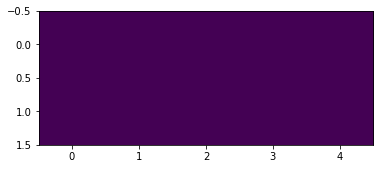

done thought:  4


In [17]:
    if b01.inputs(data, 0):
        for i in range(1):
    #         clear_output(wait=True)
            thought = b01.think(3)
            outputs = b01.outputs(0, 255, 0).reshape(-1, 5)
            print(outputs)
            plt.imshow(outputs)
            plt.show()
            time.sleep(1)
        print('done thought: ', thought)
    else:
        print('input error')